# Cleaning the Groundtruth File
0. Drop all columns where 'num_patches' == NaN
1. Only keep the columns 'PatientID', 'Histologischer Subtyp', 'WSI1', 'WSI2', 'WSI3'
2. All columns with 'Histologischer Subtyp' == 'nicht typisierbar', 'Anaplastisch', 'Desmoplastisch*', 'Desmoplastisch/Anaplastisch', 'Medullomyoblastom', 'Großzellig/anapl.' are thrown out
3. All 'klassisch' and 'Klassisch' values are renamed to CMB
4. All "Extensiv nodulär" and "Desmoplastisch" values are renamed to "DN"
5. For now, drop the columns 'WSI2', 'WSI3'
6. In column 'WSI1', there are sometimes multiple files in one column (they are split by '\n' or ' ), only utilize the first file of them

In [6]:
import pandas as pd
import os

# open xlsx as dataframe and count the all rows
df = pd.read_excel('/home/Maack/Medulloblastoma/mb_anno_070721.xlsx')

# 0.
df_cleaned = df.dropna(subset=['num_patches'])

# 1.
df_cleaned = df_cleaned[['PatientID', 'Histologischer Subtyp', 'WSI1', 'WSI2', 'WSI3']]


# 2.
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'nicht typisierbar']
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'Anaplastisch']
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'Desmoplastisch*']
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'Desmoplastisch/Anaplastisch']
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'Medullomyoblastom']
df_cleaned = df_cleaned[df_cleaned['Histologischer Subtyp'] != 'Großzellig/anapl.']

# 3.
df_cleaned['Histologischer Subtyp'] = df_cleaned['Histologischer Subtyp'].replace('klassisch', 'CMB')
df_cleaned['Histologischer Subtyp'] = df_cleaned['Histologischer Subtyp'].replace('Klassisch', 'CMB')

# 4.
df_cleaned['Histologischer Subtyp'] = df_cleaned['Histologischer Subtyp'].replace('Desmoplastisch', 'DN')
df_cleaned['Histologischer Subtyp'] = df_cleaned['Histologischer Subtyp'].replace('Extensiv nodulär', 'DN')

df_cleaned = df_cleaned.reset_index(drop=True)

# 5.
df_cleaned = df_cleaned.drop(columns=['WSI2', 'WSI3'])
files = os.listdir("/data/Maack/PANT/ndpi/NDPI")


# print all unique values of WSI1 and its number of occurences
print(df_cleaned['Histologischer Subtyp'].value_counts())

# 6.
for index, row in df_cleaned.iterrows():
    if row['WSI1'] not in files:
        new_row = row['WSI1'].split('.ndpi')
        # create new df_cleaned with new_row
        df_cleaned.loc[index, 'WSI1'] = f"{new_row[0]}.ndpi"
        
#export df_cleaned as csv
df_cleaned.to_csv('/home/Maack/Medulloblastoma/mb_anno_070721_cleaned.csv', index=False)

Histologischer Subtyp
CMB    103
DN      58
Name: count, dtype: int64


## Check if all files in mb_anno_070721_cleaned.csv occur in the NDPI folder 

In [7]:
import pandas as pd
import os

# open xlsx as dataframe and count the all rows
df = pd.read_csv('/home/Maack/Medulloblastoma/mb_anno_070721_cleaned.csv')

files = os.listdir("/data/Maack/PANT/ndpi/NDPI")


counter = 0
# check if all df[WSI1] are in /data/Maack/PANT/ndpi/NDPI
for index, row in df.iterrows():
    if row['WSI1'] not in files:
        counter += 1
        print(row['WSI1'])

print(counter)


0


## Delete all files that are not to be found in the ground truth.

In [3]:
# df = pd.read_csv('/home/Maack/Medulloblastoma/mb_anno_070721_cleaned.csv')

files = os.listdir("/data/Maack/PANT/ndpi_reduced/NDPI")

# # Delete all files in files that are not in df[WSI1]
# counter = 0
# for file in files:
#     if file not in df['WSI1'].values:
#         os.remove(f"/data/Maack/PANT/ndpi/NDPI/{file}")
#         counter += 1

# print(counter)

print(len(files))

161


# From the "mb_anno_070721_cleaned.csv" file, create a groundtruthfile for training AND testing dataset_csv/
- Since the create_splits_seq in the original repo creates 10 folds where train, val and test are always different for each fold, we first create a proper test set. Two groundtruth files are available (train_val.csv, test.csv)
- To create a proper 10-fold split, only train_val.csv is used for the create_split_seq.py file
- Afterwards the test.csv in the according format is concated to each of the 10 splits.csv
- Now, for each split, the testing images are the same

*This is imporant, because we must'nt use the test images for pretraining*

In [30]:
import pandas as pd
df = pd.read_csv('/home/Maack/Medulloblastoma/mb_anno_070721_cleaned.csv')

df.head()


# rename the columns from PatientID to case_id and Histologischer Subtyp to label and WSI1 to slide_id
df = df.rename(columns={'PatientID': 'case_id', 'Histologischer Subtyp': 'label', 'WSI1': 'slide_id'})
# change position of columns to case_id, slide_id, label
df = df[['case_id', 'slide_id', 'label']]


# from df create a subdataframe with 20% of the rows and 'label' value 'CMB' only
df_test_CMB = df[df['label'] == 'CMB'].sample(frac=0.175, random_state=42)
# from df create a subdataframe with 20% of the rows and 'label' value 'CMB' only
df_test_DN = df[df['label'] == 'DN'].sample(frac=0.25, random_state=42)

# concat df_test_CMB and df_test_DN to df_test
df_test = pd.concat([df_test_CMB, df_test_DN])

# from df create a subdataframe with all rows that are not in df_test
df_train_val = df.drop(df_test.index)

# print len of df_test and df_train_val
print(len(df))
print(len(df_test))
print(len(df_train_val))



# save the df_test as csv
df_test.to_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv', index=False)

# save the df_train_val as csv
df_train_val.to_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_train_val.csv', index=False)

161
32
129


### Fuse the two csv files (needed for the main.py file)

In [31]:
import pandas as pd
# load '/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv' to pandas df
df_test = pd.read_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv')
df_test['slide_id'] = df_test['slide_id'].str.replace('.ndpi', '')
df_test.to_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv', index=False)

# load '/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_train_val.csv' to pandas df
df_train_val = pd.read_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_train_val.csv')
df_train_val['slide_id'] = df_train_val['slide_id'].str.replace('.ndpi', '')
df_train_val.to_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_train_val.csv', index=False)

# create a new df with df_test concated to df_train_val
df = pd.concat([df_test, df_train_val])

df.head()

# save the df as csv
df.to_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN.csv', index=False)

### Helper to visualize images from the test_list

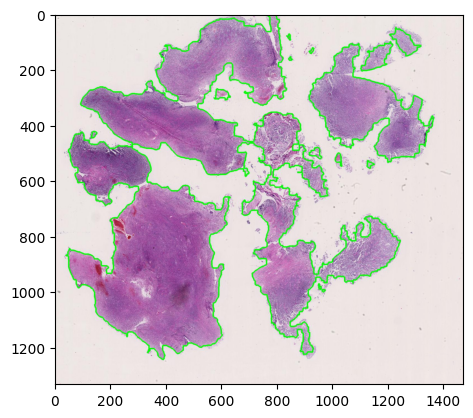

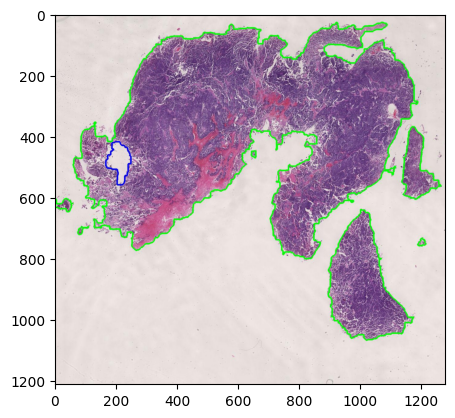

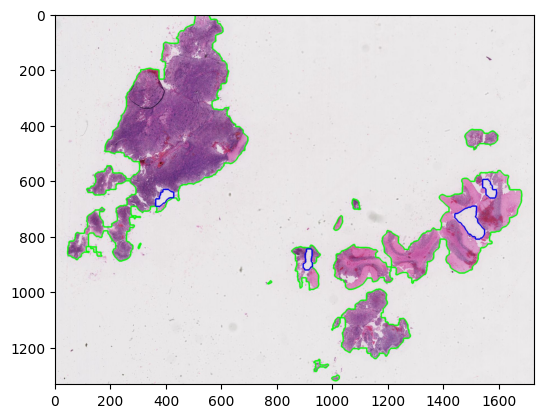

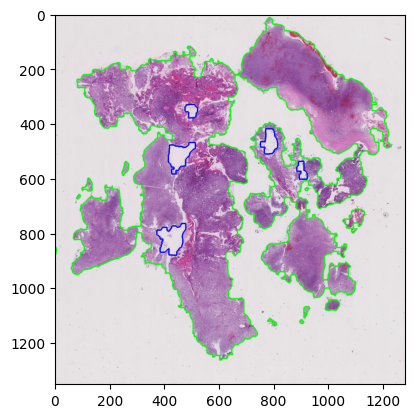

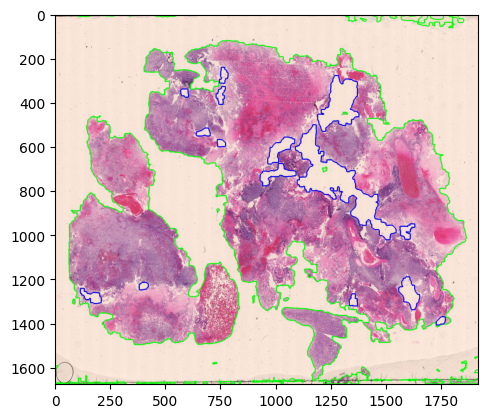

KeyboardInterrupt: 

In [25]:
# create a list from the df_test[slice_id] column


df_test = pd.read_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv')
test_list = df_test['slide_id'].tolist()

# the path to folder is /home/Maack/Medulloblastoma/CLAM/experiments/001/masks, the image names are stored in test_list
# open all .jpg images that are stored in test_list and visualize them
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

path = '/home/Maack/Medulloblastoma/CLAM/experiments/002/masks'

for file in test_list:
    img = mpimg.imread(os.path.join(path, f"{file}.jpg"))
    plt.imshow(img)
    plt.show()

## Create the train_val_test split
1. Create the train_val split via create_splits_seq
2. Adapt splits_i_bool.csv, splits_descriptor.csv, splits_i.csv such that they contain test.csv content

### 1.

In [32]:
!python /home/Maack/Medulloblastoma/CLAM/create_splits_seq.py --task CMB_vs_DN_train_val --seed 1

label column: label
label dictionary: {'CMB': 0, 'DN': 1}
number of classes: 2
slide-level counts:  
 label
1    44
0    85
Name: count, dtype: int64
Patient-LVL; Number of samples registered in class 0: 85
Slide-LVL; Number of samples registered in class 0: 85
Patient-LVL; Number of samples registered in class 1: 44
Slide-LVL; Number of samples registered in class 1: 44

number of training samples: 103
number of samples in cls 0: 68
number of samples in cls 1: 35

number of val samples: 26
number of samples in cls 0: 17
number of samples in cls 1: 9

number of test samples: 0



number of training samples: 103
number of samples in cls 0: 68
number of samples in cls 1: 35

number of val samples: 26
number of samples in cls 0: 17
number of samples in cls 1: 9

number of test samples: 0



number of training samples: 103
number of samples in cls 0: 68
number of samples in cls 1: 35

number of val samples: 26
number of samples in cls 0: 17
number of samples in cls 1: 9

number of test sam

### 2.

In [33]:
import pandas as pd
# add test images into split_i_bool.csv

n_folds = 10

for j in range(n_folds):
    df_bool = pd.read_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}_bool.csv')
    df_describtor = pd.read_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}_descriptor.csv')
    df = pd.read_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}.csv')
    df_test = pd.read_csv('/home/Maack/Medulloblastoma/CLAM/dataset_csv/CMB_vs_DN_test.csv')

    # iterate through each row in df_test and
    # 1. add a new row to df_bool
    # 2. Edit the number of test images in df_describtor
    # 3. Add test slide ids to the df test columns
    counter_CMB = 0
    counter_DN = 0
    for i, (index, row) in enumerate(df_test.iterrows()):
        # 1.
        new_row = {"Unnamed: 0" :row["slide_id"], "train": False, "val": False, "test": True}
        df_bool = pd.concat([df_bool, pd.DataFrame([new_row])], ignore_index=True)
        df_bool.to_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}_bool.csv', index=False)
        
        # 2.
        if row["label"] == "CMB":
            counter_CMB += 1
        if row["label"] == "DN":
            counter_DN += 1

        df_describtor.loc[df_describtor['Unnamed: 0'] == 'CMB', 'test'] = counter_CMB
        df_describtor.loc[df_describtor['Unnamed: 0'] == 'DN', 'test'] = counter_DN
        df_describtor.to_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}_descriptor.csv', index=False)

        # 3.
        df.iloc[i, df.columns.get_loc("test")] = row["slide_id"]
        df.to_csv(f'/home/Maack/Medulloblastoma/CLAM/splits/CMB_vs_DN_train_val_100/splits_{j}.csv', index=False)

#### Check how many patches there are per WSI

In [ ]:
import h5py
import os

# open h5py file

path = '/home/Maack/Medulloblastoma/CLAM/experiments/002/patches'

counter = 0
all_features = 0
for file in os.listdir(path):
    if file.endswith(".h5"):
        # open h5py file
        with h5py.File(os.path.join(path, file), 'r') as h5f:
            counter += 1
            print(file)
            print(h5f['coords'].shape[0])
            all_features += h5f['coords'].shape[0]
            print()

print(counter)

print()
print(all_features/counter)
